In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import shapefile
from shapely.geometry import mapping, Polygon 
import time
import wget
import rioxarray as rio
import xarray as xr
import numpy as np
import datetime as dt

In [3]:
class Reader:
    def __init__(self):
        self.shapefile = None
        self.indexes = None
        self.df_features = None
        self.projections = None
        self.NORTHWEST_KNOWLEDGE = "http://www.northwestknowledge.net/metdata/data/"


    def read_shapefile(self, shapefile="./vector_input/mtbs_fod_pts_data/mtbs_FODpoints_DD.shp",
                       indexes=None,
                       db_features=None):
        
        self.shapefile = gpd.read_file(shapefile)
        if(indexes != None):
            self.indexes = gpd.read_file(indexes)
        if(db_features != None):
            self.db_features = pd.DataFrame(gpd.read_file(db_features))

    def output_shapefile(self, print_head=False, print_columns=False, print_extra_variables=False, close_window_after_sleep=True, plot_file=True):
        if(print_head):
            print(self.shapefile.head())
        if(print_columns):
            print(self.shapefile.columns)
        if(print_extra_variables):
            print(self.indexes.head())
            print(self.indexes.columns)
            print(self.db_features.head())
            print(self.db_features.columns)
        #print(self.projections)
        self.shapefile.plot()
        if(plot_file):
            plt.show()
            if (close_window_after_sleep):
                time.sleep(5)
                plt.close()

    def inspect_polygons(self):
        for row in self.shapefile['geometry']:
            print(row)
            """
            has list of polygons and multipolygons
            """

    def plot_polygon(self, polygons_to_plot=1):
        for index, row in self.shapefile.iterrows():
            #for col in self.shapefile.columns:
            #print(col + ": " + str(self.shapefile.iloc[index][col]) + "\n")
            print("about to plot")
            poly = gpd.GeoSeries(row.geometry)
            print(poly)
            poly.plot()
            print("plotted")
            plt.show()
            time.sleep(5)
            plt.close()
            
    def retrieve_state(self, state):
        poly = self.shapefile.loc[self.shapefile['NAME'].str.lower() == state.lower(), "geometry"]
        return poly
    
    def plot_state(self, polygon):
        polygon.plot()
        plt.show()
        
    def read_netcdf_from_web(self, variable, year, source=None):
        if source == None:
            source  = self.NORTHWEST_KNOWLEDGE
        url = source+str(variable)+"_"+str(year)+".nc"
        file = wget.download(url)
        return file
    
    def load_file_into_xarray(self, variable, year, use_downloaded_file=True):
        
        if(use_downloaded_file):
            filename = "input/" + variable.lower() + "_" + str(year) + ".nc"
            file_xarray = xr.open_dataset(filename)
        else:
            filename = self.read_netcdf_from_web(variable, year)
            file_xarray = xr.open_dataset(filename)
        return file_xarray

In [4]:
netfile = Reader()

In [5]:
xar = netfile.load_file_into_xarray("sph", 2020, False)

100% [......................................................................] 187171109 / 187171109

In [6]:
print(xar)
netfile.read_shapefile("./vector_input/US_States/cb_2018_us_state_500k/cb_2018_us_state_500k.shp", None, None)

<xarray.Dataset>
Dimensions:            (lon: 1386, lat: 585, day: 366, crs: 1)
Coordinates:
  * lon                (lon) float64 -124.8 -124.7 -124.7 ... -67.1 -67.06
  * lat                (lat) float64 49.4 49.36 49.32 ... 25.15 25.11 25.07
  * day                (day) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * crs                (crs) uint16 3
Data variables:
    specific_humidity  (day, lat, lon) float32 ...
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       03 March 2021
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Develop

  STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry  
0  MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...  
1  MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...  
2  POLYGON ((-103.00257 36.52659, -103.00219 36.6...  
3  MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...  
4  POLYGON ((-82.64320 38.16909, -82.64300 38.169...  
Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSP

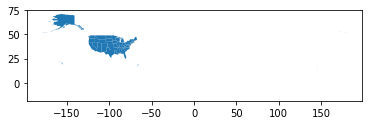

In [7]:
netfile.output_shapefile(True, True, False, False, False)

In [8]:
montana_poly = netfile.retrieve_state("Montana")


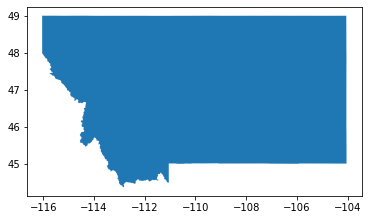

In [9]:
netfile.plot_state(montana_poly)

In [10]:
file = netfile.read_netcdf_from_web("sph", 2020)


100% [......................................................................] 187171109 / 187171109

In [11]:
xr = rio.open_rasterio(file)

In [12]:
#xr_masked = xr.fillna(0)
xr_masked = xr.where(xr != xr.attrs['_FillValue'])

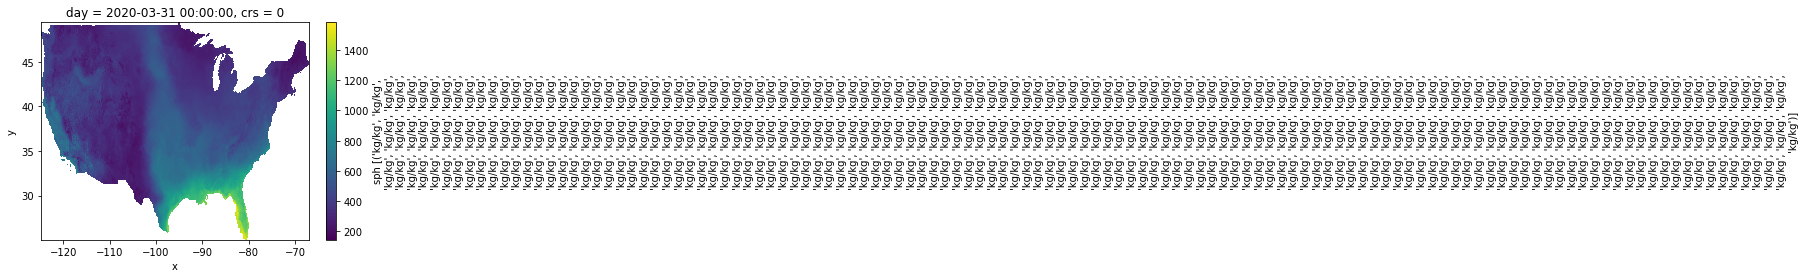

In [13]:
date = "2020/01/31" # "yyyy/mm/dd"
day = (dt.date(int(date[0:4]), int(date[5:7]), int(date[8:])) - dt.date(int(date[0:4]), 1, 1)).days
date = "2020/03/31" # "yyyy/mm/dd"
day2 = (dt.date(int(date[0:4]), int(date[5:7]), int(date[8:])) - dt.date(int(date[0:4]), 1, 1)).days
xr_masked[day2, :, :].plot() # 32st day of entire netcdf file for us

In [14]:
print(montana_poly.crs)
print(type(xr_masked))


epsg:4269
<class 'xarray.core.dataarray.DataArray'>


In [15]:
clipped = xr_masked.rio.write_crs(montana_poly.crs).rio.clip(montana_poly.geometry.apply(mapping))

<xarray.DataArray 'specific_humidity' (y: 111, x: 288)>
array([[  789.,   762.,   770., ...,   616.,   617.,   615.],
       [  768.,   768.,   763., ...,   615.,   615.,   614.],
       [  782.,   795.,   776., ...,   612.,   609.,   607.],
       ...,
       [32767., 32767., 32767., ..., 32767., 32767., 32767.],
       [32767., 32767., 32767., ..., 32767., 32767., 32767.],
       [32767., 32767., 32767., ..., 32767., 32767., 32767.]])
Coordinates:
  * y            (y) float64 48.98 48.94 48.9 48.86 ... 44.53 44.48 44.44 44.4
  * x            (x) float64 -116.0 -116.0 -115.9 ... -104.1 -104.1 -104.1
    day          object 2020-05-30 00:00:00
    crs          int32 0
    spatial_ref  int32 0
Attributes:
    add_offset:         0.0
    coordinates:        lon lat
    coordinate_system:  WGS84,EPSG:4326
    description:        Daily mean specific humidity (2m)
    dimensions:         lon lat time
    long_name:          sph
    scale_factor:       1e-05
    standard_name:      sph
    u

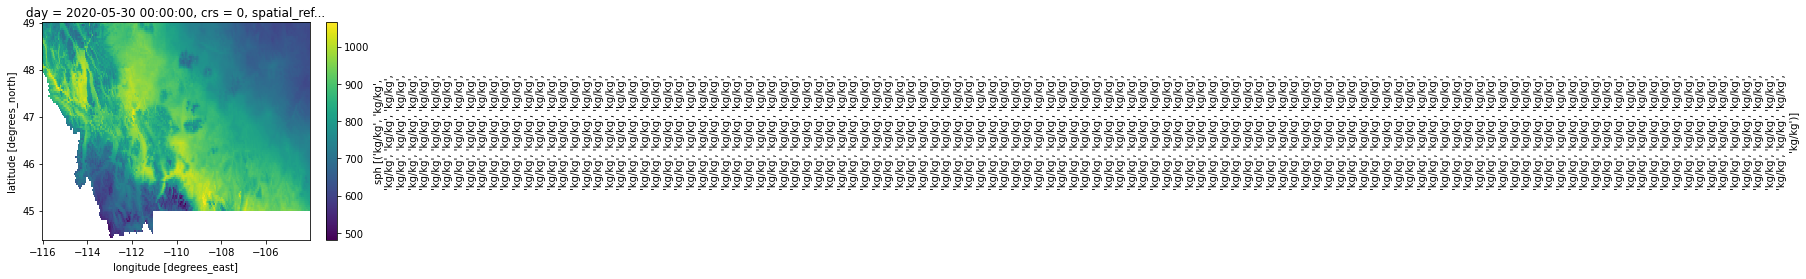

In [16]:
#clipped._FillValue = 0
print(clipped[150, :, :])
clipped = clipped.where(clipped != clipped.attrs['_FillValue'])
clipped[150, :, :].plot()

<xarray.DataArray 'specific_humidity' (y: 111, x: 288)>
array([[682., 666., 671., ..., 910., 912., 914.],
       [666., 676., 673., ..., 901., 904., 901.],
       [681., 700., 677., ..., 888., 887., 888.],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Coordinates:
  * y            (y) float64 48.98 48.94 48.9 48.86 ... 44.53 44.48 44.44 44.4
  * x            (x) float64 -116.0 -116.0 -115.9 ... -104.1 -104.1 -104.1
    day          object 2020-07-19 00:00:00
    crs          int32 0
    spatial_ref  int32 0
Attributes:
    add_offset:         0.0
    coordinates:        lon lat
    coordinate_system:  WGS84,EPSG:4326
    description:        Daily mean specific humidity (2m)
    dimensions:         lon lat time
    long_name:          sph
    scale_factor:       1e-05
    standard_name:      sph
    units:              ('kg/kg', 'kg/kg', 'kg/kg', 'kg/kg', 'kg/kg', 'kg/kg'

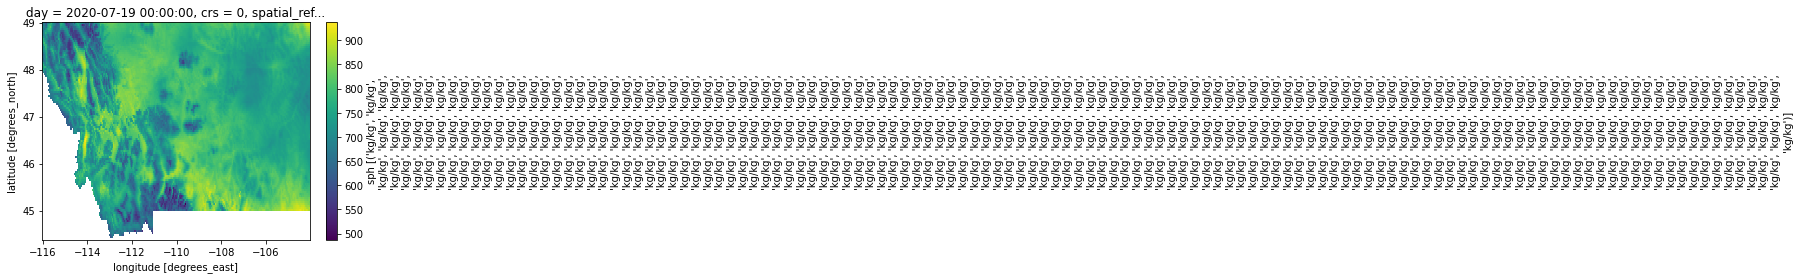

In [17]:
print(clipped[200, :, :]) # set up conversion of date to number ie january 31 = 31, 07-19 = 200
clipped[200, :, :].plot()

In [18]:
type(clipped)


xarray.core.dataarray.DataArray

In [19]:
# !pip install folium
# import folium
# from folium import plugins


In [20]:
#lookup simplify for simplifying polygon for faster optimization

In [21]:
#floium explore for dataframes
#gpd (instance).folium.explore

<xarray.DataArray 'specific_humidity' (y: 5, x: 5)>
array([[414., 388., 399., 401., 388.],
       [387., 389., 398., 403., 397.],
       [401., 417., 399., 395., 390.],
       [412., 406., 398., 412., 412.],
       [386., 409., 412., 400., 384.]])
Coordinates:
  * y            (y) float64 48.98 48.94 48.9 48.86 48.82
  * x            (x) float64 -116.0 -116.0 -115.9 -115.9 -115.8
    day          object 2020-01-01 00:00:00
    crs          int32 0
    spatial_ref  int32 0
Attributes:
    add_offset:         0.0
    coordinates:        lon lat
    coordinate_system:  WGS84,EPSG:4326
    description:        Daily mean specific humidity (2m)
    dimensions:         lon lat time
    long_name:          sph
    scale_factor:       1e-05
    standard_name:      sph
    units:              ('kg/kg', 'kg/kg', 'kg/kg', 'kg/kg', 'kg/kg', 'kg/kg'...
    _Unsigned:          true
    _FillValue:         32767.0
<xarray.DataArray 'x' (x: 5)>
array([-116.016667, -115.975   , -115.933333, -115.891667,

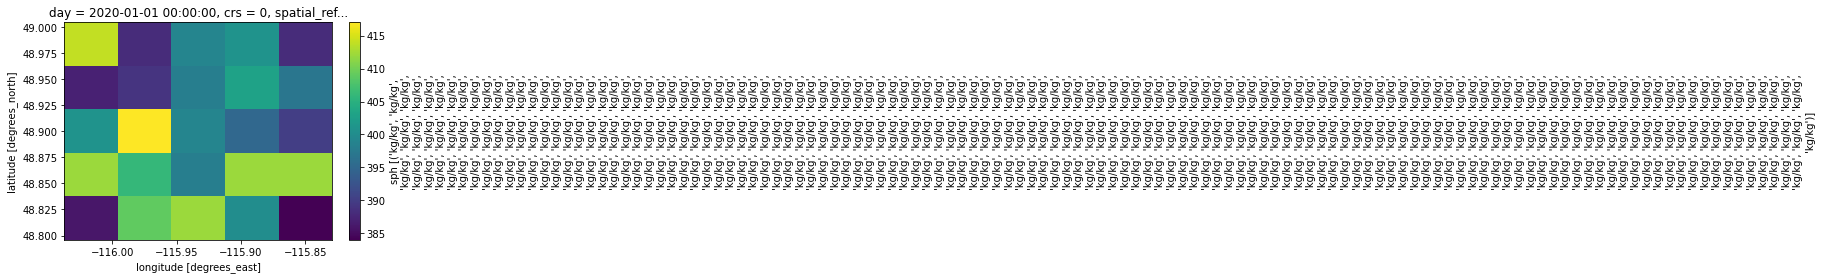

In [37]:
print(clipped[0,:,:].head())
print(clipped[0,:,:].head().x)
print(clipped[0,:,:].head().y)
clipped[0,:,:].head().plot()



In [24]:
clipped[0,0,0]

<xarray.DataArray 'specific_humidity' ()>
array(414.)
Coordinates:
    y            float64 48.98
    x            float64 -116.0
    day          object 2020-01-01 00:00:00
    crs          int32 0
    spatial_ref  int32 0
Attributes:
    add_offset:         0.0
    coordinates:        lon lat
    coordinate_system:  WGS84,EPSG:4326
    description:        Daily mean specific humidity (2m)
    dimensions:         lon lat time
    long_name:          sph
    scale_factor:       1e-05
    standard_name:      sph
    units:              ('kg/kg', 'kg/kg', 'kg/kg', 'kg/kg', 'kg/kg', 'kg/kg'...
    _Unsigned:          true
    _FillValue:         32767.0

In [28]:
clipped[0,0,0].x


<xarray.DataArray 'x' ()>
array(-116.01666663)
Coordinates:
    y            float64 48.98
    x            float64 -116.0
    day          object 2020-01-01 00:00:00
    crs          int32 0
    spatial_ref  int32 0
Attributes:
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [29]:
clipped[0,0,0].y

<xarray.DataArray 'y' ()>
array(48.98333333)
Coordinates:
    y            float64 48.98
    x            float64 -116.0
    day          object 2020-01-01 00:00:00
    crs          int32 0
    spatial_ref  int32 0
Attributes:
    axis:           Y
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north

In [30]:
clipped[0,1,0].x

<xarray.DataArray 'x' ()>
array(-116.01666663)
Coordinates:
    y            float64 48.94
    x            float64 -116.0
    day          object 2020-01-01 00:00:00
    crs          int32 0
    spatial_ref  int32 0
Attributes:
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [32]:
clipped[0,0,2].y

<xarray.DataArray 'y' ()>
array(48.98333333)
Coordinates:
    y            float64 48.98
    x            float64 -115.9
    day          object 2020-01-01 00:00:00
    crs          int32 0
    spatial_ref  int32 0
Attributes:
    axis:           Y
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north

In [38]:
test_y = 48.87
test_x = -115.91

In [60]:
def find_nearest(array, value, return_index = True):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin() - 1 # - 1 is to go to the preceding index, assuming pixel coordinate is upper left
    idx = 0 if idx < 0 else idx
    if return_index:
        return idx
    return array[idx]

In [61]:
# print(clipped[0,:,:].head().x)
# print(clipped[0,:,:].head().y)
found_x = find_nearest(clipped[0,:,:].head().x, test_x)
print(found_x)


2


In [62]:
found_y = find_nearest(clipped[0,:,:].head().y, test_y)
print(found_y)

2


In [63]:
pixel = clipped[0,found_y, found_x]

In [79]:
pixel.values == 399

True